# DSSM-LSTM Model for LIAR-2 Dataset

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Divinor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Divinor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# DSSM-LSTM Model Definition
class DSSM_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(DSSM_LSTM, self).__init__()

        # Linear layer to project input features
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # Fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)  # Linear projection
        x = x.unsqueeze(1)  # Add sequence dimension for LSTM
        lstm_out, _ = self.lstm(x)
        hidden = lstm_out[:, -1, :]
        output = self.fc2(self.dropout(hidden))
        return output

In [3]:
# Preprocessing and loading data
def preprocess_data(filepath):
    data = pd.read_csv(filepath)

    # Drop unnecessary columns
    columns_to_drop = ['id', 'date', 'speaker', 'state_info', 'justification']
    data = data.drop(columns=columns_to_drop, errors='ignore')

    # Fill missing values with empty strings
    data = data.fillna("")

    # Tokenize and combine all text columns
    # text_columns = ['statement', 'subject', 'speaker_description', 'context']
    # text_columns = ['statement']
    # text_columns = ['subject']
    # text_columns = ['speaker_description']
    text_columns = ['context']
    data['text'] = data[text_columns].apply(lambda x: " ".join(x), axis=1)

    # Map labels
    data['label'] = pd.to_numeric(data['label'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
    valid_labels = [0, 1, 2, 3, 4, 5]  # Valid labels for the LIAR2 dataset
    data = data[data['label'].isin(valid_labels)]  # Keep only rows with valid labels

    if data.empty:
        raise ValueError(f"Processed dataset is empty after preprocessing {filepath}. Check your data.")

    return data

In [4]:
# Extract features using TfidfVectorizer
def extract_features(data, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), tokenizer=word_tokenize)
        X = vectorizer.fit_transform(data['text']).toarray()
    else:
        X = vectorizer.transform(data['text']).toarray()

    y = data['label'].values
    return X, y, vectorizer


In [22]:
# Evaluate model predictions
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    y_test = np.array(y_true)  # Convert tensor to numpy array
    test_predictions = np.array(y_pred)
    
    # Unique classes in the dataset
    classes = np.unique(y_true)

    # Binarize the true labels
    y_test_binarized = label_binarize(y_true, classes=classes)
    predictions_binarized = label_binarize(y_pred, classes=classes)
    
    # Binarize the true labels
    y_test_binarized = label_binarize(y_true, classes=classes)
    predictions_binarized = label_binarize(y_pred, classes=classes)

    # Create plot
    plt.figure(figsize=(10, 7))
    
    # Loop through each class
    for i, class_label in enumerate(classes):
        # Compute precision, recall, and thresholds
        precision, recall, _ = precision_recall_curve(
            y_test_binarized[:, i], predictions_binarized[:, i]
        )
        # Compute average precision score
        avg_precision = average_precision_score(
            y_test_binarized[:, i], predictions_binarized[:, i]
        )
        # Plot the PR curve
        plt.plot(recall, precision, label=f'Class {class_label} (AP={avg_precision:.2f})')
    
    # Plot configurations
    plt.title("Precision-Recall Curve (Multiclass)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [11]:
# Train and evaluate DSSM-LSTM
def train_dssm_lstm(X_train, y_train, X_valid, y_valid, X_test, y_test):
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    y_valid = torch.tensor(y_valid, dtype=torch.long)

    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Model parameters
    input_dim = X_train.shape[1]
    hidden_dim = 128
    output_dim = 6  # Number of label categories
    dropout = 0.5

    # Initialize model, loss, and optimizer
    model = DSSM_LSTM(input_dim, hidden_dim, output_dim, dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)

    # Training loop
    epochs = 20
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid)
        valid_preds = torch.argmax(valid_outputs, dim=1)
        return model, y_valid, valid_preds
        print("Validation Results:")
        evaluate_model(y_valid, valid_preds)

    # Evaluate on test set
    with torch.no_grad():
        test_outputs = model(X_test)
        test_preds = torch.argmax(test_outputs, dim=1)
        print("Test Results:")
        evaluate_model(y_test, test_preds)

In [12]:
# Example usage
def main(train_path, valid_path, test_path):
    # Preprocess data
    train_data = preprocess_data(train_path)
    valid_data = preprocess_data(valid_path)
    test_data = preprocess_data(test_path)

    # Extract features
    X_train, y_train, vectorizer = extract_features(train_data)
    X_valid, y_valid, _ = extract_features(valid_data, vectorizer)
    X_test, y_test, _ = extract_features(test_data, vectorizer)

    # Train and evaluate DSSM-LSTM
    model, y_valid, valid_preds = train_dssm_lstm(X_train, y_train, X_valid, y_valid, X_test, y_test)
    return model, y_valid, valid_preds

if __name__ == "__main__":
    train_path = "train.csv"
    valid_path = "valid.csv"
    test_path = "test.csv"
    model, y_valid, valid_preds = main(train_path, valid_path, test_path)

C:\Users\Divinor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/20, Loss: 1.7832036018371582
Epoch 2/20, Loss: 1.7824134826660156
Epoch 3/20, Loss: 1.7816319465637207
Epoch 4/20, Loss: 1.780820608139038
Epoch 5/20, Loss: 1.779939889907837
Epoch 6/20, Loss: 1.7791802883148193
Epoch 7/20, Loss: 1.7784600257873535
Epoch 8/20, Loss: 1.777493953704834
Epoch 9/20, Loss: 1.7768149375915527
Epoch 10/20, Loss: 1.7757512331008911
Epoch 11/20, Loss: 1.7748615741729736
Epoch 12/20, Loss: 1.7738698720932007
Epoch 13/20, Loss: 1.772767186164856
Epoch 14/20, Loss: 1.771868348121643
Epoch 15/20, Loss: 1.7707353830337524
Epoch 16/20, Loss: 1.7694447040557861
Epoch 17/20, Loss: 1.768405795097351
Epoch 18/20, Loss: 1.7669861316680908
Epoch 19/20, Loss: 1.7657047510147095
Epoch 20/20, Loss: 1.7644485235214233


Accuracy: 0.28776665215498476
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.29      1.00      0.45       661
           2       0.00      0.00      0.00       361
           3       0.00      0.00      0.00       371
           4       0.00      0.00      0.00       343
           5       0.00      0.00      0.00       258

    accuracy                           0.29      2297
   macro avg       0.05      0.17      0.07      2297
weighted avg       0.08      0.29      0.13      2297



C:\Users\Divinor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Divinor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Divinor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classi

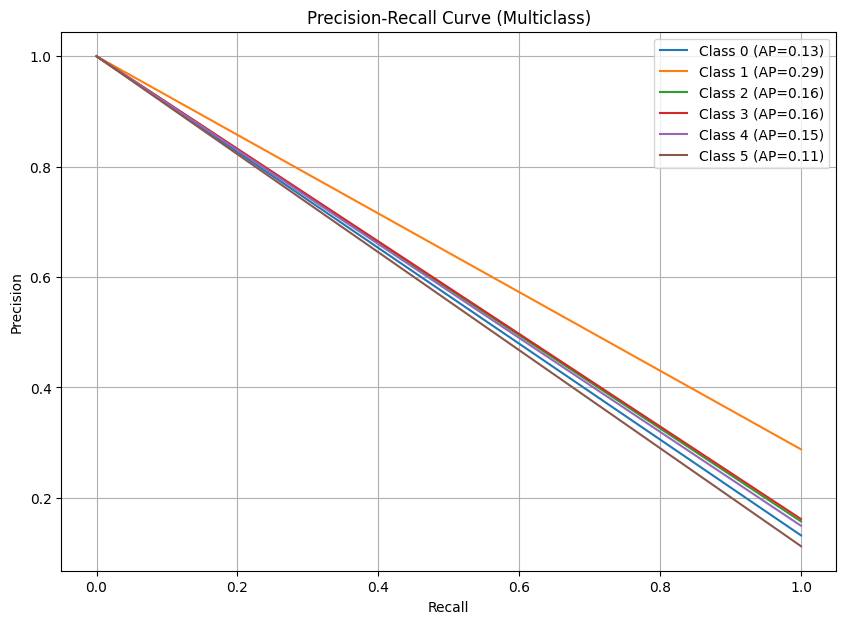

In [23]:
evaluate_model(y_valid, valid_preds)